In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne 
from nice.markers import (KolmogorovComplexity, TimeLockedContrast, PowerSpectralDensityEstimator, PowerSpectralDensitySummary,
                          PowerSpectralDensity, SymbolicMutualInformation, PermutationEntropy, TimeLockedTopography, ContingentNegativeVariation)

import pycsd

from utils import make_str_label, all_markers

Using MNE with API > 0.19


# Compute markers function

In [7]:
def all_markers(epochs, tmin, tmax, target, epochs_erp = None):
        """
        Computes all ther markers for given epochs.
        epochs: the epochs from which to compute the markers
        tmin: min time for computing markers 
        tmax: max time to compute markers
        target: reduction target, epochs or topography
        epochs_erp: if a different preprocessed epochs are used for computing ERP
        
        Evoked markers have already defined times
        """
        if epochs_erp ==None:
            epochs_erp = epochs
        
        from scipy.stats import trim_mean
        
        def trim_mean80(a, axis=0):
            return trim_mean(a, proportiontocut=.1, axis=axis)       

        # =============================================================================
        # SPECTRAL MARKERS
        # =============================================================================
          #PowerSpectralDensityL
        psds_params = dict(n_fft=4096, n_overlap=100, n_jobs='auto', nperseg=128)
        base_psd = PowerSpectralDensityEstimator(
            psd_method='welch', tmin=tmin, tmax=tmax, fmin=1., fmax=45.,
            psd_params=psds_params, comment='default')
        


        reduction_func = [{'axis': 'frequency', 'function': np.sum},
             {'axis': 'channels', 'function': np.mean},
             {'axis': 'epochs', 'function': trim_mean80}]
        
        ###alpha normalized###
        alpha = PowerSpectralDensity(estimator=base_psd, fmin=8., fmax=13.,normalize=True, comment='alpha')
        alpha.fit(epochs)
        dataalpha_n = alpha._reduce_to(reduction_func, target=target, picks=None)

        #alpha
        alpha = PowerSpectralDensity(estimator=base_psd, fmin=8., fmax=13.,normalize=False, comment='alpha')
        alpha.fit(epochs)
        dataalpha = alpha._reduce_to(reduction_func, target=target, picks=None)

        #delta normalized
        delta = PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=4.,normalize=True, comment='delta')
        delta.fit(epochs)
        datadelta_n = delta._reduce_to(reduction_func, target=target, picks=None)


        #delta
        delta = PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=4,normalize=False, comment='delta')
        delta.fit(epochs)
        datadelta = delta._reduce_to(reduction_func, target=target, picks=None)

        #theta normalized
        theta = PowerSpectralDensity(estimator=base_psd, fmin=4., fmax=8.,normalize=True, comment='theta')
        theta.fit(epochs)
        datatheta_n = theta._reduce_to(reduction_func, target=target, picks=None)


        #theta
        theta = PowerSpectralDensity(estimator=base_psd, fmin=4., fmax=8,normalize=False, comment='theta')
        theta.fit(epochs)
        datatheta = theta._reduce_to(reduction_func, target=target, picks=None)

        #gamma normalized
        gamma = PowerSpectralDensity(estimator=base_psd, fmin=30., fmax=45.,normalize=True, comment='gamma')
        gamma.fit(epochs)
        datagamma_n = gamma._reduce_to(reduction_func, target=target, picks=None)


        #gamma
        gamma = PowerSpectralDensity(estimator=base_psd, fmin=30., fmax=45,normalize=False, comment='theta')
        gamma.fit(epochs)
        datagamma = gamma._reduce_to(reduction_func, target=target, picks=None)

        #beta normalized
        beta = PowerSpectralDensity(estimator=base_psd, fmin=13., fmax=30.,normalize=True, comment='beta')
        beta.fit(epochs)
        databetaa_n = beta._reduce_to(reduction_func, target=target, picks=None)


        #beta
        beta = PowerSpectralDensity(estimator=base_psd, fmin=13., fmax=30,normalize=False, comment='beta')
        beta.fit(epochs)
        databeta = beta._reduce_to(reduction_func, target=target, picks=None)
        
        
        
        #Spectral Entropy
        se = PowerSpectralDensity(estimator=base_psd, fmin=1., fmax=45.,
                         normalize=False, comment='summary_se')
        se.fit(epochs)
        datase = se._reduce_to(reduction_func, target=target, picks=None)
        
        
        #### Spectral Summary ####
        
        reduction_func= [{'axis': 'channels', 'function': np.mean},
             {'axis': 'epochs', 'function': trim_mean80}]
        
        # msf
        msf = PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
                                percentile=.5, comment='summary_msf')
        msf.fit(epochs)
        datamsf = msf._reduce_to(reduction_func, target=target, picks=None)
        
        #sef90
        sef90 = PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
                                percentile=.9, comment='summary_sef90')
        sef90.fit(epochs)
        datasef90 = sef90._reduce_to(reduction_func, target=target, picks=None)
        
        #sef95
        sef95 = PowerSpectralDensitySummary(estimator=base_psd, fmin=1., fmax=45.,
                                percentile=.95, comment='summary_sef95')
        sef95.fit(epochs)
        datasef95 = sef95._reduce_to(reduction_func, target=target, picks=None)

        # =============================================================================
        # INFORMATION THEORY MARKERS
        # =============================================================================
        
        ### Kolgomorov complexity ###
        komplexity = KolmogorovComplexity(tmin=tmin, tmax=tmax, backend='openmp')
        komplexity.fit(epochs)
        komplexityobject=komplexity.data_ ###Object to save, number of channels*number of epochs, it's ndarray
        reduction_func= [{'axis': 'channels', 'function': np.mean},
             {'axis': 'epochs', 'function': trim_mean80}]


        datakomplexity = komplexity._reduce_to(reduction_func, target=target, picks=None)

        
        
        
        ### Permuttion entropy ###
        p_e = PermutationEntropy(tmin=tmin, tmax=tmax, kernel=3, tau=1)
        p_e.fit(epochs)
        p_eobject = p_e.data_
        datap_e1 = p_e._reduce_to(reduction_func, target=target, picks=None)
        
        ### Permuttion entropy ###
        p_e = PermutationEntropy(tmin=tmin, tmax=tmax, kernel=3, tau=2)
        p_e.fit(epochs)
        p_eobject = p_e.data_
        datap_e2 = p_e._reduce_to(reduction_func, target=target, picks=None)
        
        ### Permuttion entropy ###
        p_e = PermutationEntropy(tmin=tmin, tmax=tmax, kernel=3, tau=4)
        p_e.fit(epochs)
        p_eobject = p_e.data_
        datap_e4 = p_e._reduce_to(reduction_func, target=target, picks=None)
        
        ### Permuttion entropy theta###
        p_e = PermutationEntropy(tmin=tmin, tmax=tmax, kernel=3, tau=8)
        p_e.fit(epochs)
        p_eobject = p_e.data_
        datap_e8 = p_e._reduce_to(reduction_func, target=target, picks=None)

        # =============================================================================
        # wSMI MARKERS
        # =============================================================================
        reduction_func= [{'axis': 'channels_y', 'function': np.median},
             {'axis': 'channels', 'function': np.mean},
             {'axis': 'epochs', 'function': trim_mean80}]
        
        ###wSMI ###
        wSMI = SymbolicMutualInformation(tmin=tmin, tmax=tmax, kernel=3, tau=1, backend="openmp",
                     method_params=None, method='weighted', comment='default')
        wSMI.fit(epochs)
        wSMIobject = wSMI.data_
        datawSMI1 = wSMI._reduce_to(reduction_func, target=target, picks=None)
        
        ###wSMI ###
        wSMI = SymbolicMutualInformation(tmin=tmin, tmax=tmax, kernel=3, tau=2, backend="openmp",
                     method_params=None, method='weighted', comment='default')
        wSMI.fit(epochs)
        wSMIobject = wSMI.data_
        datawSMI2 = wSMI._reduce_to(reduction_func, target=target, picks=None)
        
        ###wSMI ###
        wSMI = SymbolicMutualInformation(tmin=tmin, tmax=tmax, kernel=3, tau=4, backend="openmp",
                     method_params=None, method='weighted', comment='default')
        wSMI.fit(epochs)
        wSMIobject = wSMI.data_
        datawSMI4 = wSMI._reduce_to(reduction_func, target=target, picks=None)
        
        ###wSMI ###
        wSMI = SymbolicMutualInformation(tmin=tmin, tmax=tmax, kernel=3, tau=8, backend="openmp",
                     method_params=None, method='weighted', comment='default')
        wSMI.fit(epochs)
        wSMIobject = wSMI.data_
        datawSMI8 = wSMI._reduce_to(reduction_func, target=target, picks=None)
        
        
        # =============================================================================
        # EVOKED MARKERS
        # =============================================================================
        
        ###Contingent Negative Variation (CNV)###
        cnv = ContingentNegativeVariation(tmin=-0.004, tmax=0.596)
        
        reduction_func = [{'axis': 'epochs', 'function': trim_mean80},
             {'axis': 'channels', 'function': np.mean}]
        
        cnv.fit(epochs_erp)
        cnv_chs= ['AF3', 'AFz', 'AF4', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
        roi_cnv = np.array(mne.pick_channels(epochs_erp.info['ch_names'], include=cnv_chs))
        dataCNV = cnv._reduce_to(reduction_func, target=target, picks={
        'epochs': None,
        'channels': roi_cnv})
        
        ###P1###
        reduction_func = [{'axis': 'epochs', 'function': trim_mean80},
         {'axis': 'channels', 'function': np.mean},
         {'axis': 'times', 'function': np.mean}]
        p1 = TimeLockedTopography(tmin=0.068, tmax=0.116, comment='p1')
        p1.fit(epochs_erp)
        p1_chs= ['AF3', 'AFz', 'AF4', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
        roi_p1 = np.array(mne.pick_channels(epochs_erp.info['ch_names'], include=p1_chs))
        dataP1 = p1._reduce_to(reduction_func, target=target, picks={
        'epochs': None,
        'channels': roi_p1,
        'times':None})
        
        ###P3a###
        p3a = TimeLockedTopography(tmin=0.28, tmax=0.34, comment='p3a')
        reduction_func = [{'axis': 'epochs', 'function': trim_mean80},
         {'axis': 'channels', 'function': np.mean},
         {'axis': 'times', 'function': np.mean}]
        p3a.fit(epochs_erp)
        p3a_chs= ['AF3', 'AFz', 'AF4', 'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2']
        roi_p3a = np.array(mne.pick_channels(epochs_erp.info['ch_names'], include=p3a_chs))
        dataP3a= p3a._reduce_to(reduction_func, target=target, picks={
        'epochs': None,
        'channels': roi_p3a,
        'times':None})
        
        ###P3b###
        p3b = TimeLockedTopography(tmin=0.4, tmax=0.6, comment='p3b')
        reduction_func = [{'axis': 'epochs', 'function': trim_mean80},
         {'axis': 'channels', 'function': np.mean},
         {'axis': 'times', 'function': np.mean}]
        p3b.fit(epochs_erp)
        p3b_chs= ['FC1', 'FCz', 'FC2', 'C1', 'Cz','C2', 'CP1', 'CPz', 'CP2']
        roi_p3b = np.array(mne.pick_channels(epochs_erp.info['ch_names'], include=p3b_chs))
        dataP3b= p3b._reduce_to(reduction_func, target=target, picks={
        'epochs': None,
        'channels': roi_p3b,
        'times':None})
        
        ###Dictionary with all the markers###
        return {'wSMI_1':datawSMI1,'wSMI_2':datawSMI2,'wSMI_4':datawSMI4,'wSMI_8':datawSMI8, 
                'p_e_1':datap_e1,'p_e_2':datap_e2,'p_e_4':datap_e4,'p_e_8':datap_e8, 
                'k':datakomplexity, 'se':datase,
                'msf': datamsf, 'sef90':datasef90, 'sef95':datasef95,
                'b':databeta,'b_n':databetaa_n, 'g':datagamma, 'g_n':datagamma_n, 
                't':datatheta,'t_n': datatheta_n , 'd':datadelta, 'd_n':datadelta_n, 
                'a_n':dataalpha_n, 'a':dataalpha, 
                'CNV':dataCNV, 'P1':dataP1, 'P3a': dataP3a, 'P3b': dataP3b}


In [5]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'


all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']


path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [62]:
participant = all_participants[1]
folder = path + participant +'/'

epochs_subtracted = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_subtracted_epo.fif') 
epochs_subtracted.info['description'] = 'biosemi/64' #necessary for wSMI 
epochs =  epochs_subtracted.pick_types(eeg = True) #EOGs break everything\


tmin = 0
tmax = 0.6
target = 'epochs'
def trim_mean80(a, axis=0):
            return trim_mean(a, proportiontocut=.1, axis=axis)       

# =============================================================================
# SPECTRAL MARKERS
# =============================================================================
  #PowerSpectralDensityL
psds_params = dict(n_fft=4096, n_overlap=100, n_jobs='auto', nperseg=128)
base_psd = PowerSpectralDensityEstimator(
    psd_method='welch', tmin=tmin, tmax=tmax, fmin=1., fmax=45.,
    psd_params=psds_params, comment='default')


reduction_func = [{'axis': 'frequency', 'function': np.sum},
     {'axis': 'channels', 'function': np.mean},
     {'axis': 'epochs', 'function': trim_mean80}]

###alpha normalized###
alpha = PowerSpectralDensity(estimator=base_psd, fmin=8., fmax=13.,normalize=True, comment='alpha')
alpha.fit(epochs)
dataalpha_n = alpha._reduce_to(reduction_func, target=target, picks=None)


Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP08/VP08_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
433 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    6.0s remaining:   17.9s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    6.2s remaining:    7.4s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    6.6s remaining:    3.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.8s remaining:    1.0s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    7.0s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]


In [60]:
reduction_func = [    {'axis': 'frequency', 'function': np.sum}, {'axis': 'epochs', 'function': np.mean},
     {'axis': 'channels', 'function': np.mean},
]

dataalpha_n = alpha._reduce_to(reduction_func, target=target, picks=None)

Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']


In [51]:
import seaborn as sns

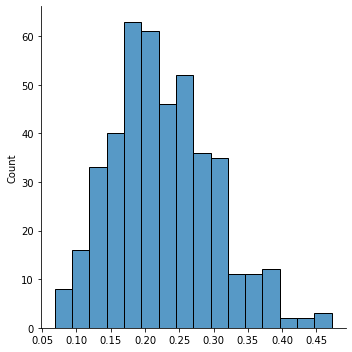

In [63]:
sns.displot(dataalpha_n)


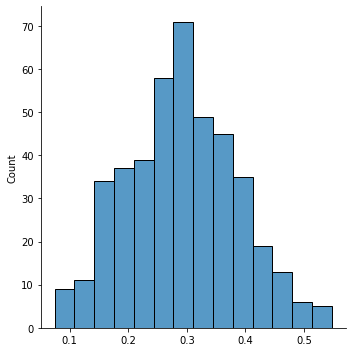

In [53]:
sns.displot(dataalpha_n)


In [32]:
len(dataalpha_n)

TypeError: object of type 'numpy.float64' has no len()

# Compute markers for all subjects

In [9]:
target = 'epochs'

for i in all_participants:
    participant = i
    
    print('')
    print('#########################################')
    print(f'Computing markers for participant {participant}')
    print('#########################################')
    print('')
    

    folder = path + participant +'/'

    
    df_markers = pd.DataFrame()
    df_markers['participant'] = participant
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs_subtracted = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_subtracted_epo.fif') 
    epochs_subtracted.info['description'] = 'biosemi/64' #necessary for wSMI 
    epochs_subtracted =  epochs_subtracted.pick_types(eeg = True) #EOGs break everything\
    
    df_subtracted = pd.DataFrame.from_dict(all_markers(epochs_subtracted, 0, 0.6, target))
    
    df_subtracted = df_subtracted.assign(
    events = epochs_subtracted.events[:,2],
    label = lambda df: df.events.apply(lambda x: make_str_label(x)).str.split('/'), 
    probe = lambda df: df.label.apply(lambda x: x[0]),
    mind = lambda df: df.label.apply(lambda x: x[1]),
    stimuli = lambda df: df.label.apply(lambda x: x[2]),
    correct = lambda df: df.label.apply(lambda x: x[3]), 
    prev_trial = lambda df: df.label.apply(lambda x: x[4]),
    segment = lambda df: df.label.apply(lambda x: x[5]),
    preproc = 'subtracted',
    epoch_type = epoch_type
    )
    
    df_markers = df_markers.append(df_subtracted)
        
    ##################
    #### With ERP ####
    ##################
    epochs_erp = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif')
    epochs_erp.info['description'] = 'biosemi/64' #necessary for wSMI
    epochs_erp =  epochs_erp.pick_types(eeg = True) #EOGs break everything
    
    df_erp = pd.DataFrame.from_dict(all_markers(epochs_erp, 0, 0.6, target))
    
    df_erp = df_erp.assign(
    events = epochs_erp.events[:,2],
    label = lambda df: df.events.apply(lambda x: make_str_label(x)).str.split('/'), 
    probe = lambda df: df.label.apply(lambda x: x[0]),
    mind = lambda df: df.label.apply(lambda x: x[1]),
    stimuli = lambda df: df.label.apply(lambda x: x[2]),
    correct = lambda df: df.label.apply(lambda x: x[3]), 
    prev_trial = lambda df: df.label.apply(lambda x: x[4]),
    segment = lambda df: df.label.apply(lambda x: x[5]),
    preproc = 'erp',
    epoch_type = epoch_type
    )
    df_markers = df_markers.append(df_erp)
    
    
    
    
    df_markers.to_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv')



#########################################
Computing markers for participant VP07
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP07/VP07_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    5.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.24259448051452637 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP07/VP07_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
174 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    4.9s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.1s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:    0.1s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 174 out of 174 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP08
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP08/VP08_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
433 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.8s remaining:   14.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.9s remaining:    5.8s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.1s remaining:    2.5s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.3s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.6254439353942871 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    0.6s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    0.6s finished


Filtering  at 20.83 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    2.1s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    3.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP08/VP08_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
433 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    8.7s remaining:   26.2s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    9.1s remaining:   10.8s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    9.4s remaining:    4.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    9.7s remaining:    1.4s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    9.8s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    2.2s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    4.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 382 tasks      | elapsed:    1.5s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    1.8s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 254 tasks      | elapsed:    1.0s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    1.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 214 tasks      | elapsed:    0.5s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 433 out of 433 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP09
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP09/VP09_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
334 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.4s remaining:   16.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.7s remaining:    6.7s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.9s remaining:    2.9s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.2s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.3s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.45206427574157715 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP09/VP09_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
334 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.6s remaining:   13.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.9s remaining:    5.7s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.3s remaining:    2.6s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.5s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    0.4s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 262 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 334 out of 334 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP10
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP10/VP10_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.6s remaining:    5.5s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.8s remaining:    2.4s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.9s remaining:    0.7s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.1s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.17809295654296875 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    1.8s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.2s finished


Filtering  at 20.83 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP10/VP10_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.6s remaining:    5.5s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.7s remaining:    2.4s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.9s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.0s finished


Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.17969274520874023 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 130 out of 130 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP11
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP11/VP11_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.8s remaining:    0.7s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.9s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.27799510955810547 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.4s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP11/VP11_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.9s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.9s finished


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2920839786529541 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
U

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  34 tasks      | elapsed:    0.1s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP12
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP12/VP12_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    3.9s remaining:    2.0s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.0s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.1s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.07646703720092773 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    1.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP12/VP12_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    3.8s remaining:   11.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    3.8s remaining:    4.5s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    3.8s remaining:    1.9s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    3.9s remaining:    0.6s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.0s finished


Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    1.8s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs
Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:    0.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP13
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP13/VP13_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
493 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.0s remaining:   15.0s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.2s remaining:    6.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.3s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.5s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.5s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.7464020252227783 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.3s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.6s finished


Filtering  at 10.42 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP13/VP13_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
493 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.1s remaining:   15.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.3s remaining:    6.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.4s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.5s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 102 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 223 tasks      | elapsed:    0.4s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 493 out of 493 | elapsed:    0.6s finished


Filtering  at 10.42 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP14
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP14/VP14_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
486 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size :

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.0s remaining:   15.0s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.1s remaining:    6.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.3s remaining:    2.6s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.4s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.5s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.73661208152771 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.5s finished


Filtering  at 20.83 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.5s finished


Filtering  at 10.42 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP14/VP14_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
486 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.1s remaining:   15.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.2s remaining:    6.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.4s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.5s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    2.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.5s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.4s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 486 out of 486 | elapsed:    0.5s finished


Filtering  at 10.42 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP18
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP18/VP18_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size :

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.7s remaining:   14.1s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.8s remaining:    5.7s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.9s remaining:    2.5s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.0s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.1s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.46575355529785156 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  58 tasks      | elapsed:    0.1s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP18/VP18_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
331 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.5s remaining:   13.5s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.6s remaining:    5.4s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.7s remaining:    2.4s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.8s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.9s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 260 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 331 out of 331 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP19
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP19/VP19_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.7s remaining:    5.5s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.8s remaining:    2.4s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.9s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.9s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.42311716079711914 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 258 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP19/VP19_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
294 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.3s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 258 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP20
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP20/VP20_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.37151455879211426 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP20/VP20_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.9s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.2s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 102 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 262 out of 262 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP22
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP22/VP22_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    5.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2582118511199951 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/defau

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    1.9s finished


Filtering  at 83.33 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP22/VP22_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    4.9s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.1s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2610464096069336 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
U

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 182 out of 182 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP23
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP23/VP23_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
563 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.2s remaining:   15.5s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.3s remaining:    6.3s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.5s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.7s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.8254332542419434 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    2.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 384 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP23/VP23_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
563 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.1s remaining:   15.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.3s remaining:    6.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.4s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.6s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    2.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 384 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 384 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 563 out of 563 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP24
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP24/VP24_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.4s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.5s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.31247472763061523 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['cha

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.6s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP24/VP24_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.4s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.5s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 224 out of 224 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP25
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP25/VP25_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
274 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.2s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.38753700256347656 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP25/VP25_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
274 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   13.0s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 274 out of 274 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP26
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP26/VP26_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
544 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.2s remaining:   15.5s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.3s remaining:    6.3s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.4s remaining:    2.7s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.6s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.7816400527954102 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    2.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 383 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 383 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP26/VP26_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
544 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.4s remaining:   16.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.6s remaining:    6.7s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.8s remaining:    2.9s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.0s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.1s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    2.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 383 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 383 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 383 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 544 out of 544 | elapsed:    0.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP27
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP27/VP27_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
166 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.1s remaining:    4.9s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.2s remaining:    2.1s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.23925280570983887 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    1.9s finished


Filtering  at 83.33 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP27/VP27_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
166 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    5.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished


Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.23579740524291992 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/defa

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    1.9s finished


Filtering  at 83.33 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 112 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 166 out of 166 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP28
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP28/VP28_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
164 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.1s remaining:   12.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.2s remaining:    4.9s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.1s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.3s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2301006317138672 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  58 tasks      | elapsed:    0.1s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 130 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 130 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP28/VP28_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
164 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.0s remaining:   12.1s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.1s remaining:    4.9s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.2s remaining:    2.1s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.3s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.3s finished


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.23560738563537598 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 130 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 130 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 130 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 164 out of 164 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP29
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP29/VP29_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
385 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.7s remaining:   14.2s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.9s remaining:    5.8s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.1s remaining:    2.5s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.2s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.2s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.5588324069976807 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.7s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 208 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 208 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP29/VP29_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
385 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.9s remaining:   14.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.1s remaining:    6.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    5.2s remaining:    2.6s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    5.3s remaining:    0.8s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    5.4s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    2.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 385 out of 385 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP30
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP30/VP30_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
738 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.8s remaining:   17.5s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    6.1s remaining:    7.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    6.3s remaining:    3.1s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.5s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 1.079134225845337 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    2.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.8s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.8s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP30/VP30_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
738 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.8s remaining:   17.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    6.0s remaining:    7.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    6.2s remaining:    3.1s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.4s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.5s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    2.6s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 393 tasks      | elapsed:    0.6s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 393 tasks      | elapsed:    0.5s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 393 tasks      | elapsed:    0.5s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.7s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP31
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP31/VP31_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.2s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.28613829612731934 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP31/VP31_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
201 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.4s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.289578914642334 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing s

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 201 out of 201 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP32
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP32/VP32_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
697 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.9s remaining:   17.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    6.1s remaining:    7.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    6.3s remaining:    3.1s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.5s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 1.0342624187469482 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
U

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    2.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 391 tasks      | elapsed:    0.6s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 391 tasks      | elapsed:    0.6s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.8s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 391 tasks      | elapsed:    0.6s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP32/VP32_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
697 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    5.7s remaining:   17.2s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    5.9s remaining:    7.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    6.1s remaining:    3.1s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    6.3s remaining:    0.9s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    6.4s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    2.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.7s finished


Filtering  at 41.67 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.7s finished


Filtering  at 20.83 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 510 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 697 out of 697 | elapsed:    0.7s finished


Filtering  at 10.42 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP33
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP33/VP33_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size :

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.5s remaining:   13.4s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.6s remaining:    5.4s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.7s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.8s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.8s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.4098796844482422 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.8s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.3s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.5s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP33/VP33_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.4s remaining:   13.3s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.5s remaining:    5.4s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.7s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.8s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.8s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    2.1s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 193 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 287 out of 287 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP35
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP35/VP35_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.9s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.7s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.3258655071258545 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP35/VP35_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.4s remaining:    2.2s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 231 out of 231 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP36
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP36/VP36_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.3s remaining:   12.8s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.5s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.6s finished
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2817075252532959 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing 

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP36/VP36_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.6s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.0s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.3s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.4s finished


Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.2919657230377197 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    1.9s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.2s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 202 out of 202 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']

#########################################
Computing markers for participant VP37
#########################################

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP37/VP37_evoked_ar_subtracted_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.4s remaining:   13.2s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.5s remaining:    5.3s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.7s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.8s finished


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensit

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:128: RuntimeWarning: invalid value encountered in true_divide
  self.data_norm_ = self.data_ / self.data_.sum(axis=-1)[..., None]
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/markers/spectral.py:220: RuntimeWarning: divide by zero encountered in log10
  out = 10 * np.log10(out)


Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.3111145496368408 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing symbolic transformation


/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s


Filtering  at 83.33 Hz


[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    2.0s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP37/VP37_evoked_ar_rereferenced_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Autodetected number of jobs 24
Effective window size : 16.384 (s)


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   6 out of  24 | elapsed:    4.2s remaining:   12.7s
[Parallel(n_jobs=24)]: Done  11 out of  24 | elapsed:    4.3s remaining:    5.1s
[Parallel(n_jobs=24)]: Done  16 out of  24 | elapsed:    4.4s remaining:    2.2s


Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/alpha: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/delta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']


[Parallel(n_jobs=24)]: Done  21 out of  24 | elapsed:    4.5s remaining:    0.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    4.5s finished


Reduction order for nice/marker/PowerSpectralDensity/gamma: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/theta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/beta: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensity/summary_se: ['frequency', 'channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_msf: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef90: ['channels']
Reduction order for nice/marker/PowerSpectralDensitySummary/summary_sef95: ['channels']
Running KolmogorovComplexity
Elapsed time 0.31459832191467285 sec
Reduction order for nice/marker/KolmogorovComplexity/default: ['channels']
Filtering  at 83.33 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 41.67 Hz
Performing

/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: divide by zero encountered in log
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/nice-0.1.dev0-py3.7.egg/nice/algorithms/information_theory/permutation_entropy.py:75: RuntimeWarning: invalid value encountered in multiply
  pe = np.nan_to_num(-np.nansum(count * np.log(count), axis=1))


Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 20.83 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Filtering  at 10.42 Hz
Performing symbolic transformation
Reduction order for nice/marker/PermutationEntropy/default: ['channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    1.9s finished


Filtering  at 83.33 Hz
Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s


Filtering  at 41.67 Hz


[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 20.83 Hz


[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.3s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Autodetected number of jobs 2
Computing CSD
Using 10-5 locations for CSD
Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering  at 10.42 Hz


[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 220 out of 220 | elapsed:    0.4s finished


Reduction order for nice/marker/SymbolicMutualInformation/default: ['channels_y', 'channels']
Reduction order for nice/marker/ContingentNegativeVariation/default: ['channels']
Reduction order for nice/marker/TimeLockedTopography/p1: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3a: ['channels', 'times']
Reduction order for nice/marker/TimeLockedTopography/p3b: ['channels', 'times']
